In [1]:
# загружаем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss
import shap
%config InlineBackend.figure_format = 'retina'

In [2]:
# загружаем исторический набор
data = pd.read_csv('Data/paribas_train.csv')

In [3]:
# удаляем переменную ID
data.drop('ID', axis=1, inplace=True)
# импутируем пропуски
data.fillna(-9999, inplace=True)

In [4]:
# разбиваем набор на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1), 
    data['target'], 
    test_size=0.3,
    stratify=data['target'],
    random_state=42)

In [5]:
# увеличиваем количество отображаемых столбцов
pd.set_option('max_columns', 150)
# выводим матрицу корреляций
corr = X_train.corr()
corr.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v23,v25,v26,v27,v28,v29,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v48,v49,v50,v51,v53,v54,v55,v57,v58,v59,v60,v61,v62,v63,v64,v65,v67,v68,v69,v70,v72,v73,v76,v77,v78,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v108,v109,v111,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
v1,1.000000,0.999315,0.999315,0.947288,1.000000,1.000000,0.947393,0.999619,0.022242,0.999924,0.022906,1.000000,0.005391,0.999924,0.998909,0.999315,1.000000,0.999772,0.999873,0.003925,0.983690,0.947393,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.027628,1.000000,0.947277,0.999772,-0.002806,0.999924,0.029099,1.000000,1.000000,0.999924,0.999315,1.000000,0.947393,0.999315,1.000000,0.022686,0.983640,0.999924,0.947393,1.000000,1.000000,0.999923,0.999314,1.000000,0.999315,0.019282,0.947393,0.999315,0.999873,1.000000,0.999924,0.998909,0.947059,0.021167,0.999924,0.999315,1.000000,0.998909,0.999619,0.947284,0.947308,1.000000,1.000000,0.983565,1.000000,0.946570,1.000000,0.947393,0.999924,0.999772,1.000000,1.000000,0.999772,1.000000,0.999772,0.946718,1.000000,0.999923,0.999315,0.972723,1.000000,1.000000,0.946671,0.999315,0.947289,0.947289,1.000000,0.017955,0.998909,0.999924,0.947278,0.999772,0.983614,0.999924,0.999873,0.999619,0.983640,0.947393,1.000000,1.000000,0.947289,0.011179,0.999772,0.998909
v2,0.999315,1.000000,1.000000,0.947958,0.999315,0.999315,0.948062,0.998934,0.022263,0.999239,0.022928,0.999315,0.005398,0.999239,0.998224,1.000000,0.999315,0.999086,0.999188,0.003971,0.984384,0.948063,0.999315,0.999315,0.999315,0.999315,0.999315,0.999315,0.027654,0.999315,0.947947,0.999086,-0.002894,0.999239,0.029122,0.999315,0.999315,0.999239,1.000000,0.999315,0.948062,1.000000,0.999315,0.022708,0.984335,0.999239,0.948062,0.999315,0.999315,0.999238,1.000000,0.999315,1.000000,0.019179,0.948063,1.000000,0.999188,0.999315,0.999239,0.998224,0.947729,0.021019,0.999239,1.000000,0.999315,0.998224,0.998934,0.947954,0.947978,0.999315,0.999315,0.984260,0.999315,0.947240,0.999315,0.948063,0.999239,0.999086,0.999315,0.999315,0.999086,0.999315,0.999086,0.947388,0.999315,0.999238,1.000000,0.973436,0.999315,0.999315,0.947340,1.000000,0.947959,0.947959,0.999315,0.017971,0.998224,0.999239,0.947949,0.999086,0.984309,0.999239,0.999188,0.998934,0.984334,0.948063,0.999315,0.999315,0.947959,0.011161,0.999086,0.998224
v4,0.999315,1.000000,1.000000,0.947958,0.999315,0.999315,0.948062,0.998934,0.022262,0.999239,0.022926,0.999315,0.005397,0.999239,0.998224,1.000000,0.999315,0.999086,0.999188,0.003972,0.984384,0.948062,0.999315,0.999315,0.999315,0.999315,0.999315,0.999315,0.027653,0.999315,0.947946,0.999086,-0.002901,0.999239,0.029121,0.999315,0.999315,0.999239,1.000000,0.999315,0.948062,1.000000,0.999315,0.022706,0.984334,0.999239,0.948062,0.999315,0.999315,0.999238,1.000000,0.999315,1.000000,0.019174,0.948062,1.000000,0.999188,0.999315,0.999239,0.998224,0.947728,0.021001,0.999239,1.000000,0.999315,0.998224,0.998934,0.947953,0.947977,0.999315,0.999315,0.984259,0.999315,0.947240,0.999315,0.948062,0.999239,0.999086,0.999315,0.999315,0.999086,0.999315,0.999086,0.947387,0.999315,0.999238,1.000000,0.973431,0.999315,0.999315,0.947340,1.000000,0.947958,0.947959,0.999315,0.017971,0.998224,0.999239,0.947948,0.999086,0.984309,0.999239,0.999188,0.998934,0.984334,0.948062,0.999315,0.999315,0.947959,0.011147,0.999086,0.998224
v5,0.947288,0.947958,0.947958,1.000000,0.947289,0.947288,0.999898,0.946916,0.021939,0.947214,0.022639,0.947288,0.005573,0.947214,0.946224,0.947958,0.947288,0.947066,0.947165,0.004786,0.964134,0.999898,0.947288,0.947288,0.947287,0.947289,0.947288,0.947288,0.027481,0.947289,1.000000,0.947065,-0.001230,0.947215,0.029157,0.947288,0.947288,0.947214,0.947958,0.947288,0.999898,0.947956,0.947288,0.022381,0.964085,0.947214,0.999898,0.947288,0.947289,0.947211,0.947958,0.947288,0.947958,0.017927,0.9998

In [6]:
# выделяем наиболее важные количественные признаки - те, у которых
# сумма корреляций с остальными была наименьшей
for col in corr.columns:
    print(col, np.abs(corr[col]).sum(axis=0))

v1 99.07717708071425
v2 99.05777616046353
v4 99.05772612661347
v5 96.02502215200258
v6 99.07718573728903
v7 99.07719145780698
v8 96.03328950620445
v9 99.05227072633997
v10 7.596528760721377
v11 99.07493693361639
v12 7.689686069140725
v13 99.07716443574643
v14 3.008223831271456
v15 99.07491902615293
v16 98.9893482534167
v17 99.0577192817849
v18 99.07718093373879
v19 99.06449911186405
v20 99.07131668968174
v21 3.4438744609608825
v23 98.28386173845914
v25 96.03330156366951
v26 99.07718520023877
v27 99.077190328052
v28 99.07715082089149
v29 99.07719851896434
v32 99.0771745359456
v33 99.07715843415517
v34 8.38039996397201
v35 99.07718509661052
v36 96.02409035800011
v37 99.06449480328752
v38 1.9853484500149414
v39 99.07494816262141
v40 8.530656876910994
v41 99.0771902349104
v42 99.07718593502742
v43 99.07493130569189
v44 99.05773324455026
v45 99.07716714028655
v46 96.03327981735359
v48 99.05762859475303
v49 99.07718276351144
v50 7.666519716969839
v51 98.282559421674
v53 99.07493606375925
v54

In [7]:
# формируем список важных переменных на основе корреляций
corr_select_cols = ['v10', 'v12', 'v14', 'v21', 'v34', 'v38', 
                    'v40', 'v50', 'v62', 'v72', 'v114', 'v129']

In [8]:
# формируем массив индексов категориальных признаков
categorical_features_ind = np.where(X_train.dtypes != np.float)[0]

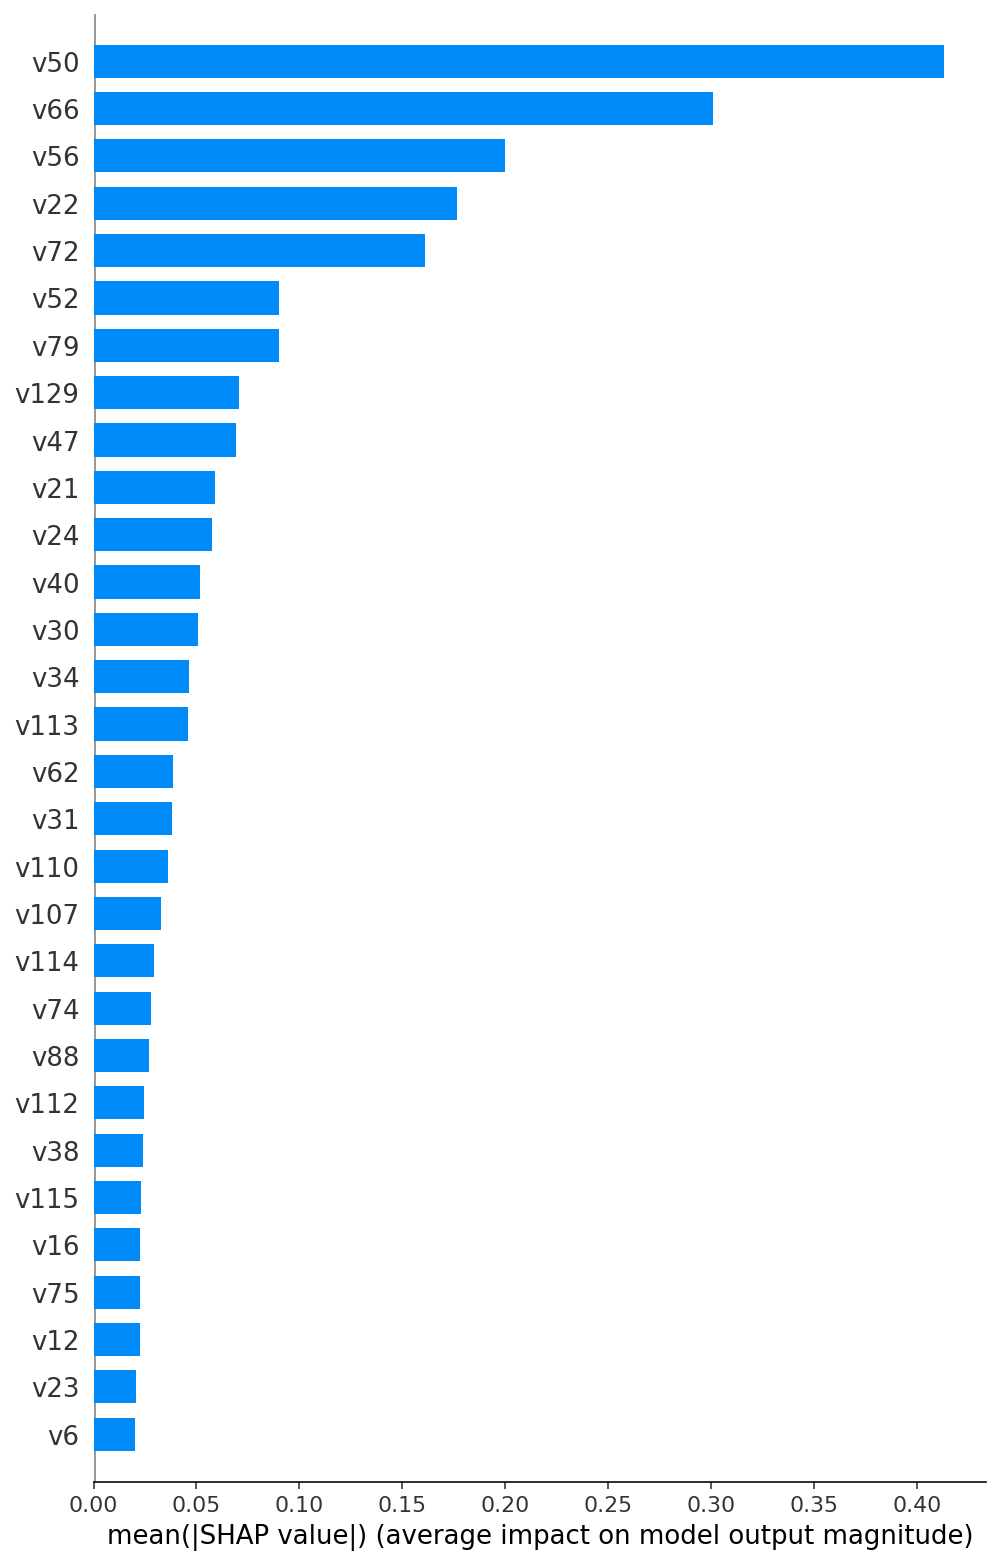

In [9]:
# формируем обучающий пул
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=categorical_features_ind)
# создаем экземпляр класса CatBoostClassifier
clf = CatBoostClassifier(learning_rate=0.08, 
                         iterations=1200,
                         random_strength=0.15,
                         random_seed=0, 
                         model_size_reg=0.1,
                         logging_level='Silent')
# обучаем модель
clf.fit(train_pool)
# вычисляем важности по SHAP
shap_values = clf.get_feature_importance(train_pool, 'ShapValues')
shap_values = shap_values[:, :-1]
# выводим график 30 наиболее важных признаков по SHAP
shap.summary_plot(shap_values, 
                  X_train, 
                  plot_type='bar', 
                  max_display=30)

In [10]:
# формируем список важных переменных на основе SHAP
shap_select_cols = ['v66', 'v56', 'v22', 'v79', 'v52', 'v24', 
                    'v47', 'v113', 'v74', 'v31', 'v110', 'v30']

In [11]:
# объединяем два созданных списка в один
select_cols = corr_select_cols + shap_select_cols

In [12]:
%%time

# загружаем наборы
train = pd.read_csv('Data/paribas_train.csv')
test = pd.read_csv('Data/paribas_test.csv')

# формируем массив меток и массив признаков
labels = train.pop('target')
# сохраняем ID набора новых данных
test_id = test['ID']

# удаляем ID
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

# импутируем пропуски
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

# формируем новые массивы признаков
train = train[select_cols]
test = test[select_cols]

# добавляем парные взаимодействия на основе категориальных 
# признаков, наиболее важных по SHAP
train['v129 + v66'] = train.apply(
    lambda x: f"{x['v129']} + {x['v66']}",
    axis=1)

train['v66 + v56'] = train.apply(
    lambda x: f"{x['v66']} + {x['v56']}",
    axis=1)

train['v56 + v22'] = train.apply(
    lambda x: f"{x['v56']} + {x['v22']}",
    axis=1)

train['v22 + v79'] = train.apply(
    lambda x: f"{x['v22']} + {x['v79']}",
    axis=1)

train['v79 + v52'] = train.apply(
    lambda x: f"{x['v79']} + {x['v52']}",
    axis=1)

train['v52 + v24'] = train.apply(
    lambda x: f"{x['v52']} + {x['v24']}",
    axis=1)

train['v24 + v47'] = train.apply(
    lambda x: f"{x['v24']} + {x['v47']}",
    axis=1)

train['v66 + v72'] = train.apply(
    lambda x: f"{x['v66']} + {x['v72']}",
    axis=1)

test['v129 + v66'] = test.apply(
    lambda x: f"{x['v129']} + {x['v66']}",
    axis=1)

test['v66 + v56'] = test.apply(
    lambda x: f"{x['v66']} + {x['v56']}",
    axis=1)

test['v56 + v22'] = test.apply(
    lambda x: f"{x['v56']} + {x['v22']}",
    axis=1)

test['v22 + v79'] = test.apply(
    lambda x: f"{x['v22']} + {x['v79']}",
    axis=1)

test['v79 + v52'] = test.apply(
    lambda x: f"{x['v79']} + {x['v52']}",
    axis=1)

test['v52 + v24'] = test.apply(
    lambda x: f"{x['v52']} + {x['v24']}",
    axis=1)

test['v24 + v47'] = test.apply(
    lambda x: f"{x['v24']} + {x['v47']}",
    axis=1)

test['v66 + v72'] = test.apply(
    lambda x: f"{x['v66']} + {x['v72']}",
    axis=1)

# формируем массив индексов категориальных признаков
cat_features_ids = np.where(train.dtypes != np.float)[0]

# формируем обучающий пул
train_pool = Pool(train, labels, cat_features=cat_features_ids)

# создаем экземпляр класса CatBoostClassifier
clf_full = CatBoostClassifier(learning_rate=0.06, 
                              iterations=1600,
                              random_strength=0.15,
                              model_size_reg=0.1,
                              random_seed=0,
                              logging_level='Silent')

# обучаем модель
clf_full.fit(train_pool)

# вычисляем вероятности
proba = clf_full.predict_proba(test)[:, 1]

# формируем посылку для Kaggle (10-е место на привате)
pd.DataFrame({'ID': test_id, 'PredictedProb': proba}).to_csv(
    'subm_improved.csv', index=False)

CPU times: user 57min 12s, sys: 14min 52s, total: 1h 12min 5s
Wall time: 8min 15s
